In [1]:
from __future__ import annotations
import os, re
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv

# 모델들(기본값 그대로 사용: 하이퍼파라미터 튜닝 X)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor

In [2]:
# -----------------------
# 0) 환경변수 로드
# -----------------------
load_dotenv()

False

In [3]:
DATA_PATH = os.getenv("DATA_PATH", "./housing_clean.csv")
TARGET    = os.getenv("TARGET", "MEDV")
TEST_SIZE = float(os.getenv("TEST_SIZE", 0.2))
SEED      = int(os.getenv("SEED", 42,))

np.random.seed(SEED)

print(f"[INFO] DATA_PATH={DATA_PATH}")
print(f"[INFO] TARGET={TARGET}, TEST_SIZE={TEST_SIZE}, SEED={SEED}")

[INFO] DATA_PATH=./housing_clean.csv
[INFO] TARGET=MEDV, TEST_SIZE=0.2, SEED=42


In [4]:
# -----------------------
# 1) CSV 탐색/로드
# -----------------------
csv_path = Path(DATA_PATH)

df = pd.read_csv(csv_path)

In [5]:
print("\n### Head ###")
print(df.head(), "\n")
print("### Info ###")
print(df.info(), "\n")
print("### Describe ###")
print(df.describe().T, "\n")


### Head ###
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2   

### Info ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NO

In [6]:
if TARGET not in df.columns:
    raise ValueError(f"TARGET='{TARGET}' not found. columns={df.columns.tolist()}")

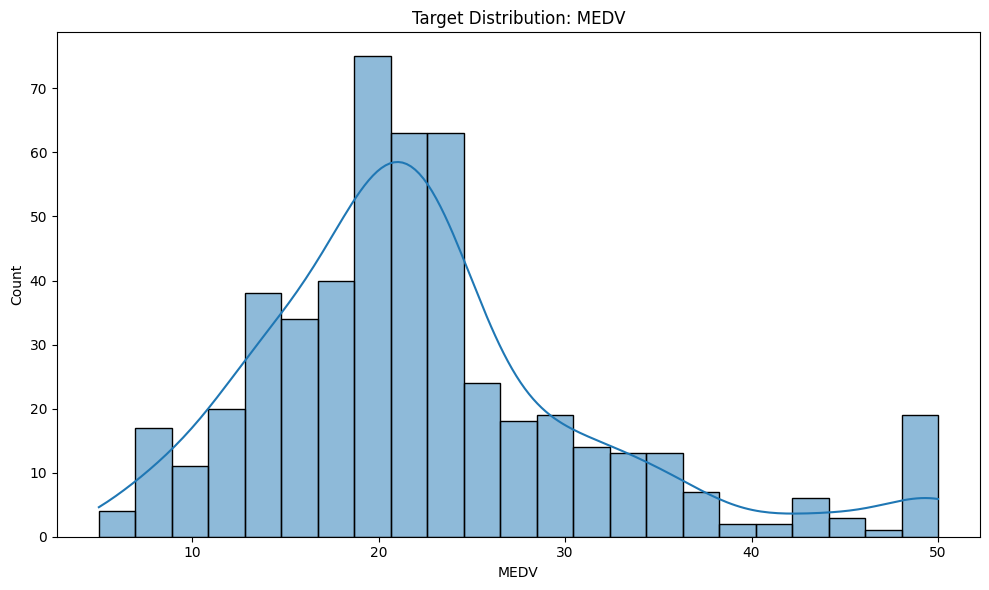

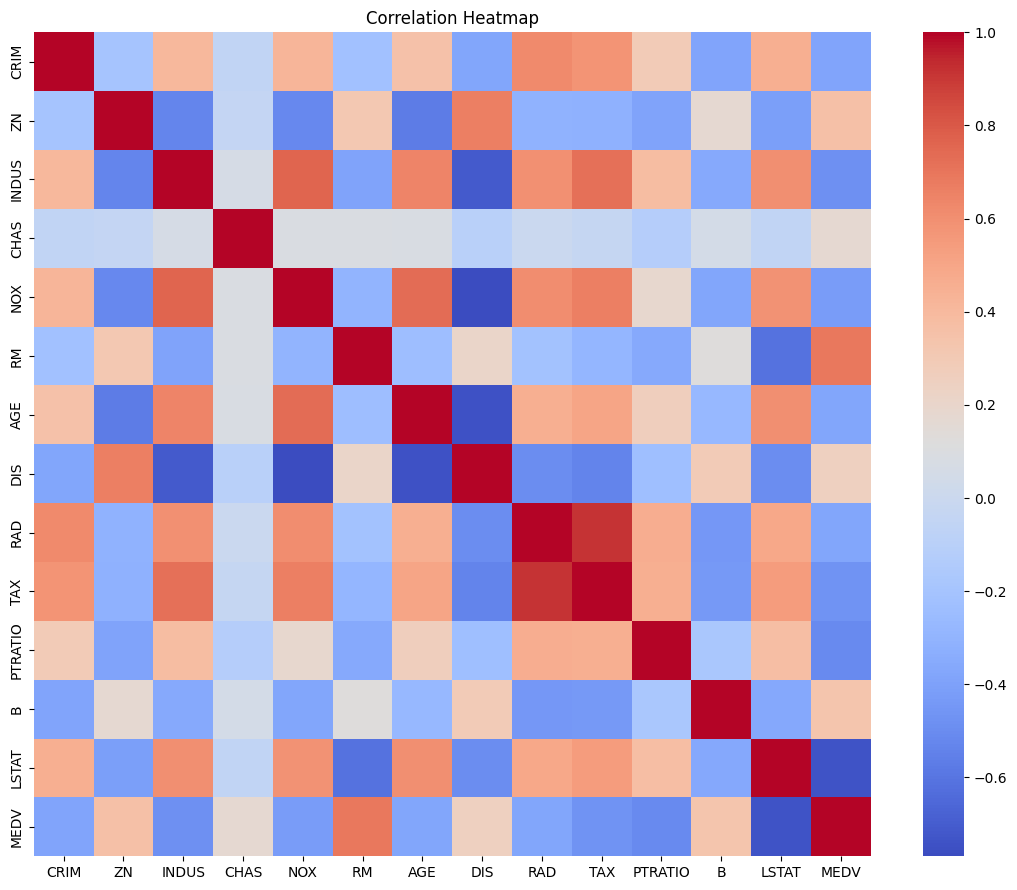

In [7]:
# -----------------------
# 2) 간단 EDA (타깃 분포, 상관관계 히트맵)
# -----------------------
plt.figure(figsize=(10,6))
sns.histplot(df[TARGET], kde=True)
plt.title(f"Target Distribution: {TARGET}")
plt.xlabel(TARGET); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,9))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap"); plt.tight_layout(); plt.show()

In [8]:
df.corr(numeric_only=True)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [9]:
# -----------------------
# 3) 결측치 처리 & 더미(필요시)
# -----------------------
# 결측치는 간단히 제거(학습 자료용 간단 전략)
df = df.dropna().reset_index(drop=True)

# 범주형이 있다면 원-핫 인코딩(보스턴은 대부분 수치형이지만 일반화)
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [10]:
# -----------------------
# 4) 데이터 분리 & 스케일링(수치형)
# -----------------------
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED
)
print(f"[INFO] X_train={X_train.shape}, X_test={X_test.shape}")

[INFO] X_train=(404, 13), X_test=(102, 13)


In [11]:
# 스케일링은 수치형만(여기선 전부 수치형일 가능성 높음)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [12]:
# -----------------------
# 5) 여러 회귀 모델 학습/평가(기본값)
# -----------------------
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),                 # 기본 alpha
    "Lasso": Lasso(max_iter=10000),   # 기본 alpha
    "ElasticNet": ElasticNet(max_iter=10000),  # 기본 alpha/l1_ratio
    "SVR": SVR(),                     # 기본(kernel=rbf, C=1.0, epsilon=0.1)
    "RandomForest": RandomForestRegressor(random_state=SEED),
    "GradientBoosting": GradientBoostingRegressor(random_state=SEED),
    "XGBoost": XGBRegressor(random_state=SEED, objective="reg:squarederror")
}


In [13]:
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

In [14]:
rows = []
for name, model in models.items():
    # 스케일링이 필요한 모델(LR/릿지/라소/엘라스틱/SVR)은 스케일된 입력 사용
    if name in {"LinearRegression","Ridge","Lasso","ElasticNet","SVR"}:
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
    else:
        # 트리/부스팅류는 원본 스케일로도 충분
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    r  = r2_score(y_test, pred)
    r_ = rmse(y_test, pred)
    rows.append({"model": name, "MAE": mae, "RMSE": r_, "R2": r})
    print(f"[{name}] MAE={mae:.3f} | RMSE={r_:.3f} | R2={r:.3f}")

[LinearRegression] MAE=3.189 | RMSE=4.929 | R2=0.669
[Ridge] MAE=3.186 | RMSE=4.931 | R2=0.668
[Lasso] MAE=3.474 | RMSE=5.251 | R2=0.624
[ElasticNet] MAE=3.431 | RMSE=5.325 | R2=0.613
[SVR] MAE=2.732 | RMSE=5.066 | R2=0.650
[RandomForest] MAE=2.040 | RMSE=2.811 | R2=0.892
[GradientBoosting] MAE=1.912 | RMSE=2.492 | R2=0.915
[XGBoost] MAE=1.891 | RMSE=2.629 | R2=0.906


In [15]:
result_df = pd.DataFrame(rows).sort_values(by=["RMSE","MAE"], ascending=[True, True])
print("\n=== Model Comparison (no tuning) ===")
print(result_df.to_string(index=False))


=== Model Comparison (no tuning) ===
           model      MAE     RMSE       R2
GradientBoosting 1.912243 2.491759 0.915334
         XGBoost 1.890887 2.628542 0.905784
    RandomForest 2.039539 2.810963 0.892253
LinearRegression 3.189092 4.928602 0.668759
           Ridge 3.185724 4.930812 0.668462
             SVR 2.731716 5.066413 0.649977
           Lasso 3.473770 5.251447 0.623943
      ElasticNet 3.431002 5.325284 0.613294


In [16]:
# -----------------------
# 6) 잔차 분석(베스트 모델)
# -----------------------
best_name = result_df.iloc[0]["model"]
print(f"\n[INFO] Best model (by RMSE/MAE): {best_name}")
best_model = models[best_name]

# 베스트 모델 입력 스케일 여부에 따라 예측
if best_name in {"LinearRegression","Ridge","Lasso","ElasticNet","SVR"}:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

residuals = y_test - y_pred_best


[INFO] Best model (by RMSE/MAE): GradientBoosting


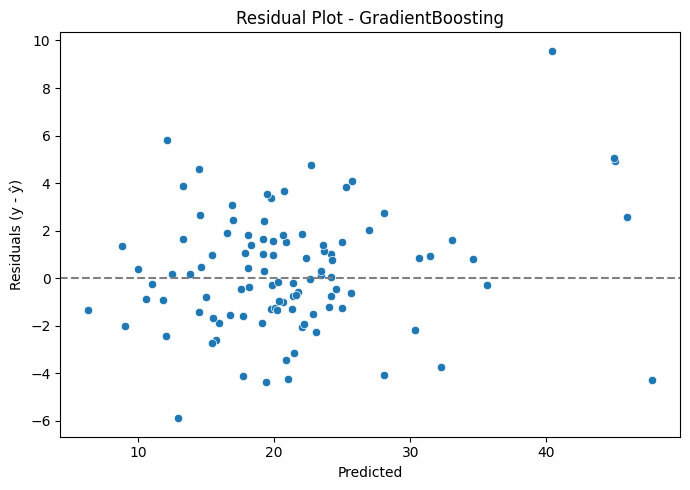

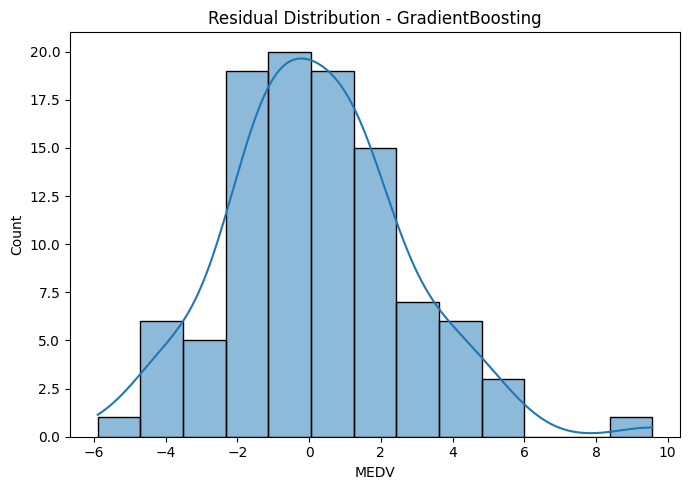

In [17]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, ls="--", color="gray")
plt.xlabel("Predicted"); plt.ylabel("Residuals (y - ŷ)")
plt.title(f"Residual Plot - {best_name}")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.title(f"Residual Distribution - {best_name}")
plt.tight_layout(); plt.show()

In [18]:
# -----------------------
# 7) 특성 중요도(가능한 모델만)
# -----------------------
def plot_feature_importance(model, feature_names, title):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        imp_df = pd.DataFrame({"feature": feature_names, "importance": imp}) \
                   .sort_values("importance", ascending=False).head(15)
        plt.figure(figsize=(8,6))
        sns.barplot(data=imp_df, x="importance", y="feature")
        plt.title(title)
        plt.tight_layout(); plt.show()


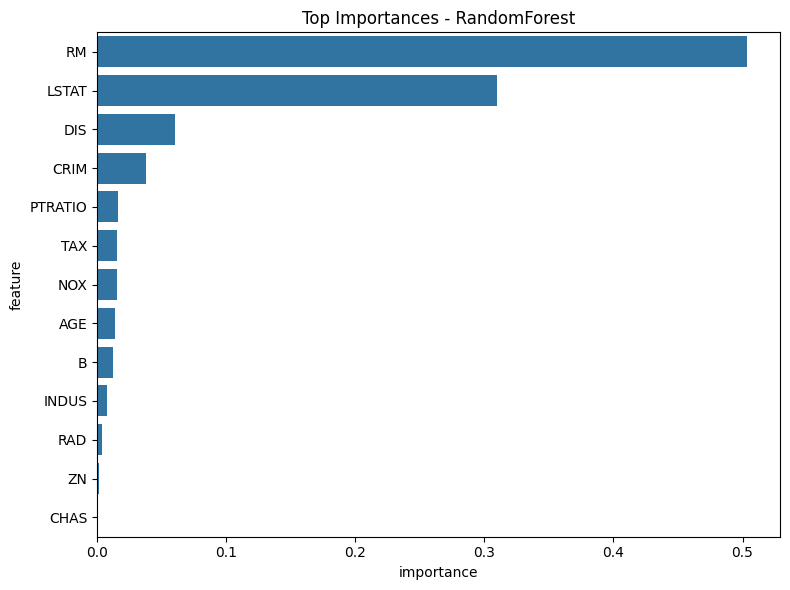

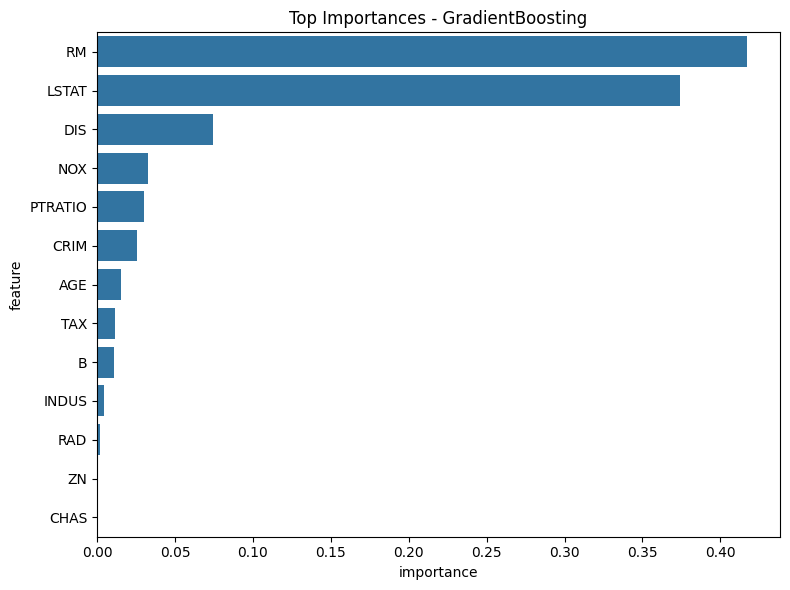

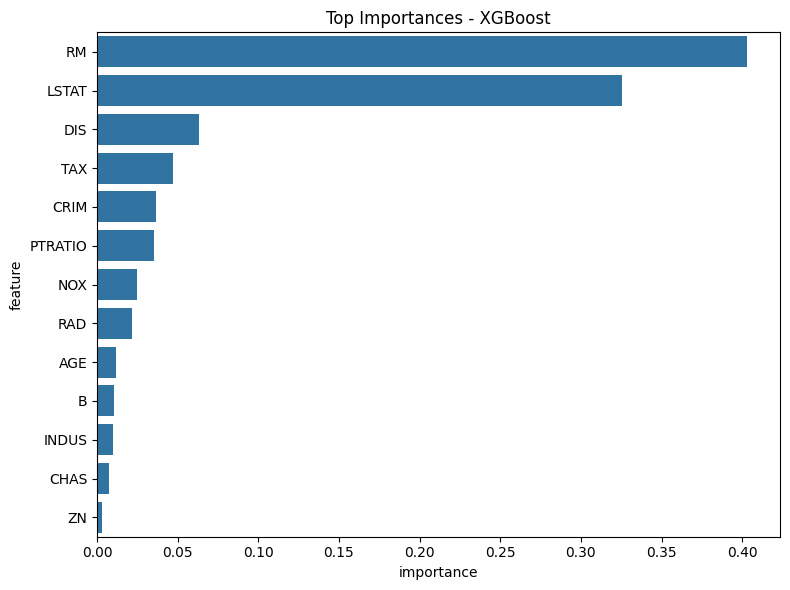

In [19]:
# 트리계열에서만 시도
for label in ["RandomForest","GradientBoosting","XGBoost"]:
    if label in models:
        mdl = models[label]
        try:
            plot_feature_importance(mdl, X.columns.tolist(), f"Top Importances - {label}")
        except Exception as e:
            print(f"[WARN] Importance not available for {label}: {e}")